# Product Review Classification

## Business Understanding
Our company wants a tool that will automatically classify product reviews as _positive_ or _negative_ reviews, based on the features of the review.  This will help our Product team to perform more sophisticated analyses in the future to help ensure customer satisfaction.

## Data Understanding
We have a labeled collection of 20,000 product reviews, with an equal split of positive and negative reviews. The dataset contains the following features:

 - `ProductId` Unique identifier for the product
 - `UserId` Unqiue identifier for the user
 - `ProfileName` Profile name of the user
 - `HelpfulnessNumerator` Number of users who found the review helpful
 - `HelpfulnessDenominator` Number of users who indicated whether they found the review helpful or not
 - `Time` Timestamp for the review
 - `Summary` Brief summary of the review
 - `Text` Text of the review
 - `PositiveReview` 1 if this was labeled as a positive review, 0 if it was labeled as a negative review

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv("reviews.csv")
df.head(3)

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,PositiveReview
0,B002QWHJOU,A37565LZHTG1VH,C. Maltese,1,1,1305331200,Awesome!,This is a great product. My 2 year old Golden ...,1
1,B000ESLJ6C,AMUAWXDJHE4D2,angieseashore,1,1,1320710400,Was there a recipe change?,I have been drinking Pero ever since I was a l...,0
2,B004IJJQK4,AMHHNAFJ9L958,A M,0,1,1321747200,These taste so bland.,"Look, each pack contains two servings of 120 c...",0


The data has already been cleaned, so there are no missing values

In [3]:
df.isna().sum()

ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Time                      0
Summary                   0
Text                      0
PositiveReview            0
dtype: int64

`PositiveReview` is the target, and all other columns are features

In [4]:
X = df.drop("PositiveReview", axis=1)
y = df["PositiveReview"]

## Data Preparation

First, split into train and test sets

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train.shape

(15000, 8)

Second, prepare for modeling. The following `Pipeline` prepares all data for modeling.  It one-hot encodes the `ProductId`, applies a tf-idf vectorizer to the `Summary` and `Text`, keeps the numeric columns as-is, and drops all other columns.

The following code may take up to 1 minute to run.

In [14]:
def drop_irrelevant_columns(X):
    return X.drop(["UserId", "ProfileName"], axis=1)

pipeline = Pipeline(steps=[
    ("drop_columns", FunctionTransformer(drop_irrelevant_columns)),
    ("transform_text_columns", ColumnTransformer(transformers=[
        ("ohe", OneHotEncoder(categories="auto", handle_unknown="ignore", sparse=False), ["ProductId"]),
        ("summary-tf-idf", TfidfVectorizer(max_features=1000), "Summary"),
        ("text-tf-idf", TfidfVectorizer(max_features=1000), "Text")
    ], remainder="passthrough")), 
])

X_train_transformed = pipeline.fit_transform(X_train)
X_test_transformed = pipeline.transform(X_test)

X_train_transformed.shape

(15000, 11275)

## Modeling

Fit a `RandomForestClassifier` with the best hyperparameters.  The following code may take up to 1 minute to run.

In [7]:
rfc = RandomForestClassifier(
    random_state=42,
    n_estimators=100,
    max_depth=30,
    min_samples_split=15,
    min_samples_leaf=1
)
rfc.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=15,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

## Model Evaluation

We are using _accuracy_ as our metric, which is the default metric in Scikit-Learn, so it is possible to just use the built-in `.score` method

In [8]:
print("Train accuracy:", rfc.score(X_train_transformed, y_train))
print("Test accuracy:", rfc.score(X_test_transformed, y_test))

Train accuracy: 0.9826666666666667
Test accuracy: 0.913


In [9]:
print("Train confusion matrix:")
print(confusion_matrix(y_train, rfc.predict(X_train_transformed)))
print("Test confusion matrix:")
print(confusion_matrix(y_test, rfc.predict(X_test_transformed)))

Train confusion matrix:
[[7312  177]
 [  83 7428]]
Test confusion matrix:
[[2293  218]
 [ 217 2272]]


In [19]:
# Create a new pipeline adding a StandardScaler() as TensorFlow likes it better
pipeline = Pipeline(steps=[
    ("drop_columns", FunctionTransformer(drop_irrelevant_columns)),
    ("transform_text_columns", ColumnTransformer(transformers=[
        ("ohe", OneHotEncoder(categories="auto", handle_unknown="ignore", sparse=False), ["ProductId"]),
        ("summary-tf-idf", TfidfVectorizer(max_features=1000), "Summary"),
        ("text-tf-idf", TfidfVectorizer(max_features=1000), "Text")
    ], remainder="passthrough")),
    ('scl', StandardScaler())   
])

X_train_transformed_scaled = pipeline.fit_transform(X_train)
X_test_transformed_scaled = pipeline.transform(X_test)

X_train_transformed_scaled.shape

(15000, 11275)

In [62]:
# Import Tensorflow and Keras
import tensorflow as tf
import tensorflow.keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Instantiate the model
model = Sequential()

# Densify by adding hidden layer
model.add(Dense(units=10, activation='relu', input_shape=(X_train_transformed_scaled.shape[1],)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['Accuracy'])
results = model.fit(X_train_transformed_scaled, y_train, validation_data=(X_test_transformed_scaled, y_test), epochs=5, batch_size=50)

Epoch 1/5
300/300 [==============================] - 3s 10ms/step - loss: 0.8123 - accuracy: 0.0000e+00 - val_loss: 0.7147 - val_accuracy: 2.0000e-04
Epoch 2/5
300/300 [==============================] - 1s 2ms/step - loss: 0.3156 - accuracy: 2.6667e-04 - val_loss: 0.4860 - val_accuracy: 0.0012
Epoch 3/5
300/300 [==============================] - 1s 2ms/step - loss: 0.1757 - accuracy: 0.0025 - val_loss: 0.4498 - val_accuracy: 0.0060
Epoch 4/5
300/300 [==============================] - 1s 2ms/step - loss: 0.1152 - accuracy: 0.0113 - val_loss: 0.4614 - val_accuracy: 0.0206
Epoch 5/5
300/300 [==============================] - 1s 2ms/step - loss: 0.0814 - accuracy: 0.0245 - val_loss: 0.4786 - val_accuracy: 0.0440


In [26]:
# results.history

{'loss': [1.2222837209701538,
  0.3503075838088989,
  0.18870316445827484,
  0.11777392774820328,
  0.08137904107570648],
 'accuracy': [0.0, 0.0, 0.0, 0.00033333332976326346, 0.0030666666571050882],
 'val_loss': [0.8161005973815918,
  0.558581531047821,
  0.5017404556274414,
  0.5160079598426819,
  0.5092464089393616],
 'val_accuracy': [0.0, 0.0, 0.0, 0.0007999999797903001, 0.008200000040233135]}

In [40]:
'''
Plotting the modell results.
Helper funtionction: plot_results(model)
       Input: results for model.fit
'''
import matplotlib.pyplot as plt
%matplotlib inline
def plot_results(model):
    
    fig, (ax1,ax2) = plt.subplots(1,2)


    ax1.plot(model.epoch, model.history['loss'], label='train')
    ax1.plot(model.epoch, model.history['val_loss'], label='val')
    ax1.set_title('Model Loss')
    
    ax1.legend()
    
    ax2.plot(model.epoch, model.history['accuracy'], label='train')
    ax2.plot(model.epoch, model.history['val_accuracy'], label='val')
    ax2.set_title('Model Accuacy')
    
    ax2.legend()

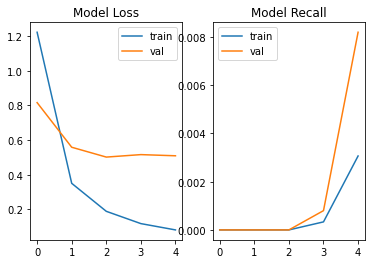

In [37]:
plot_results(results)

### Model Tuning + Feature Engineering

Epoch 1/5
270/270 [==============================] - 1s 2ms/step - loss: 1.4319 - accuracy: 0.0076 - val_loss: 1.3209 - val_accuracy: 0.0000e+00
Epoch 2/5
270/270 [==============================] - 0s 1ms/step - loss: 0.3269 - accuracy: 0.0000e+00 - val_loss: 0.6203 - val_accuracy: 0.0000e+00
Epoch 3/5
270/270 [==============================] - 0s 1ms/step - loss: 0.1803 - accuracy: 0.0000e+00 - val_loss: 0.6038 - val_accuracy: 0.0000e+00
Epoch 4/5
270/270 [==============================] - 0s 1ms/step - loss: 0.1210 - accuracy: 0.0000e+00 - val_loss: 0.5992 - val_accuracy: 0.0000e+00
Epoch 5/5
270/270 [==============================] - 0s 1ms/step - loss: 0.0873 - accuracy: 0.0000e+00 - val_loss: 0.6082 - val_accuracy: 0.0000e+00


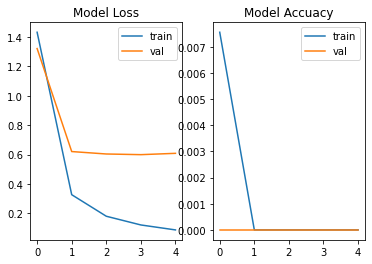

In [66]:
# Train the model with 10% data
X_t, X_val, y_t, y_val = train_test_split(X_train, y_train, random_state=42, test_size=0.1)

X_t_transformed = pipeline.fit_transform(X_t)
X_val_transformed = pipeline.transform(X_val)

# Instantiate the model
model_t = Sequential()

'''
    units=10, activation='relu', activation='sigmoid', optimizer='adam', loss='binary_crossentropy', metrics=['Accuracy']
    epochs=5, batch_size=50
'''

# Densify by adding hidden layer
model_t.add(Dense(units=10, activation='relu', input_shape=(X_t_transformed.shape[1],)))
model_t.add(Dense(1, activation='sigmoid'))
model_t.compile(optimizer='adam', loss='binary_crossentropy', metrics=['Accuracy'])
results_t = model_t.fit(X_t_transformed, y_t, validation_data=(X_val_transformed, y_val), epochs=5, batch_size=50)
plot_results(results_t)

Epoch 1/5
270/270 [==============================] - 1s 4ms/step - loss: 0.4938 - accuracy: 0.0000e+00 - val_loss: 0.4124 - val_accuracy: 0.0000e+00
Epoch 2/5
270/270 [==============================] - 0s 2ms/step - loss: 0.2157 - accuracy: 2.9630e-04 - val_loss: 0.2918 - val_accuracy: 0.0013
Epoch 3/5
270/270 [==============================] - 0s 2ms/step - loss: 0.0780 - accuracy: 0.0095 - val_loss: 0.3373 - val_accuracy: 0.0147
Epoch 4/5
270/270 [==============================] - 0s 2ms/step - loss: 0.0341 - accuracy: 0.0332 - val_loss: 0.3940 - val_accuracy: 0.0547
Epoch 5/5
270/270 [==============================] - 0s 2ms/step - loss: 0.0203 - accuracy: 0.0679 - val_loss: 0.4511 - val_accuracy: 0.1167


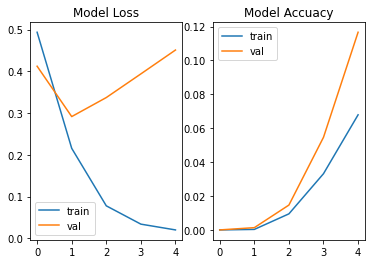

In [69]:


'''
    units=10, activation='relu', activation='sigmoid', optimizer='adam', loss='binary_crossentropy', metrics=['Accuracy']
    epochs=5, batch_size=50
    Deepen the hidden layer with 50 neurons
'''

# Densify by adding hidden layer
model_t = Sequential()
model_t.add(Dense(units=10, activation='relu', input_shape=(X_t_transformed.shape[1],)))
model_t.add(Dense(units=10, activation='relu'))
model_t.add(Dense(1, activation='sigmoid'))
model_t.compile(optimizer='adam', loss='binary_crossentropy', metrics=['Accuracy'])
results_t = model_t.fit(X_t_transformed, y_t, validation_data=(X_val_transformed, y_val), epochs=5, batch_size=50)
plot_results(results_t)

Epoch 1/5
300/300 [==============================] - 3s 12ms/step - loss: 0.0043 - accuracy: 0.1123 - val_loss: 0.9330 - val_accuracy: 0.0758
Epoch 2/5
300/300 [==============================] - 1s 3ms/step - loss: 0.0041 - accuracy: 0.1129 - val_loss: 1.0229 - val_accuracy: 0.0786
Epoch 3/5
300/300 [==============================] - ETA: 0s - loss: 0.0032 - accuracy: 0.12 - 1s 2ms/step - loss: 0.0033 - accuracy: 0.1196 - val_loss: 0.9477 - val_accuracy: 0.0808
Epoch 4/5
300/300 [==============================] - 1s 2ms/step - loss: 0.0032 - accuracy: 0.1242 - val_loss: 0.8411 - val_accuracy: 0.0856
Epoch 5/5
300/300 [==============================] - 1s 2ms/step - loss: 0.0031 - accuracy: 0.1254 - val_loss: 0.8447 - val_accuracy: 0.0838


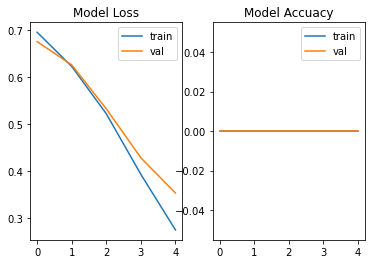

In [84]:

'''
    units=10, activation='relu', activation='sigmoid', optimizer='adam', loss='binary_crossentropy', metrics=['Accuracy']
    epochs=5, batch_size=20
    Deepen the hidden layer with 20 neurons
'''
# Densify by adding hidden layer
model_t = Sequential()
model_t.add(Dense(units=10, activation='relu', input_shape=(X_t_transformed.shape[1],)))
model_t.add(Dense(units=20, activation='relu'))
model_t.add(Dense(1, activation='sigmoid'))
model_t.compile(optimizer='adam', loss='binary_crossentropy', metrics=['Accuracy'])
results = model.fit(X_train_transformed_scaled, y_train, validation_data=(X_test_transformed_scaled, y_test), epochs=5, batch_size=50)
plot_results(results_t)


In [ ]:

'''
 - Computational complexity/resource use
   Tensorflow model learnt to be computationally expensive. As you increase the depth of the hidden layers it takes more time.
   Further processing is need to understand why both training and validation accuracies look the same.
   Training the model to decrease the loss is inconclusive at this time. Need additional strategy to build the model.
   
 - Anticipated performance on future datasets (how might the data change over time?)
   Depending on teh summary and text, the OneHotEncoded columns could explode and keep the model densly sparse. This will also incease the
   computational cost.
    
 - Types of mistakes made by the two kinds of models
   RandomForest model should remove some of the text encoding. 
   Tensorflow model should consider increasiong Epochs, however this is computationally expensive.
